# Out-of-distribution

* [You can run this example on Google Colab.](https://colab.research.google.com/github/seungjin-yang/bayesian-deep-learning/blob/master/examples/notebooks/out-of-distribution.ipynb)
* Runtime > Runtime> Change runtime type > Hardware accelerator > GPU

In [ ]:
%%bash
python -c "import google.colab"
if [[ $? == "0" ]]
then
    echo "Hello, Colab!"
    pip install tensorflow-gpu==2.0.0
    pip install tensorflow-probability==0.8.0
    pip install tensorflow-datasets==1.2.0
    pip install git+https://github.com/seungjin-yang/bayesian-deep-learning
fi

In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import tensorflow as tf
import tensorflow.keras.layers as tfkl
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import extended_tfp as extfp

tfd = tfp.distributions
tfpl = tfp.layers

### version check

In [2]:
assert tf.version.VERSION == '2.0.0'
assert tfp.__version__ == '0.8.0'
assert tfds.__version__ == '1.2.0'

### Keras backend setup

In [3]:
tf.keras.backend.set_image_data_format('channels_first')

# Dataset - MNIST

In [4]:
train_split = tfds.Split.ALL.subsplit(tfds.percent[:70])
valid_split = tfds.Split.ALL.subsplit(tfds.percent[70:85])
test_split = tfds.Split.ALL.subsplit(tfds.percent[85:])

train_dataset, mnist_info = tfds.load('mnist', split=train_split, with_info=True)
valid_dataset = tfds.load('mnist', split=valid_split)
test_dataset = tfds.load('mnist', split=test_split)

In [5]:
def preprocess_mnist(example):
    image = tf.cast(example['image'], tf.float32) / 255.
    # change the format of image from HWC to CHW.
    image = tf.transpose(image, (2, 0, 1))
    
    label = tf.one_hot(indices=example['label'], depth=10, dtype=np.int64)
    return image, label

In [6]:
train_dataset = (train_dataset
                 .map(preprocess_mnist)
                 .batch(256)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 .shuffle(int(10e3)))

valid_dataset = (valid_dataset
                .map(preprocess_mnist)
                .batch(512))

test_dataset = (test_dataset
                .map(preprocess_mnist)
                .batch(512))

In [7]:
def visualize_mnist(x, num_cols=5, image_size=2):
    x = x.squeeze()
    rank = len(x.shape)
    if rank == 2:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(x)
        ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    if rank == 3:
        num_images = len(x)
        num_rows = np.ceil(num_images / num_cols).astype(int)
        figsize = (image_size * num_cols, image_size * num_rows)
        fig, axarr = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=figsize)
        for img, ax in zip(x, axarr.flatten()):
            ax.imshow(img)
            ax.tick_params(axis='both', bottom=False, labelbottom=False, left=False, labelleft=False)

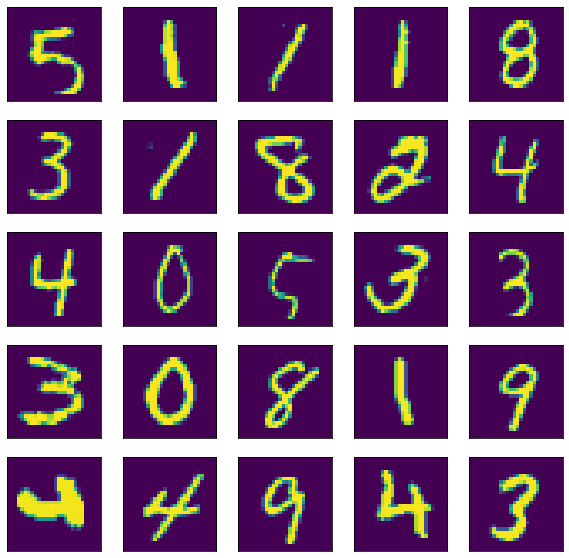

In [8]:
image, _ = next(tfds.as_numpy(test_dataset))
visualize_mnist(image[:25])

# Model Building

In [9]:
num_training_examples = int(mnist_info.splits.total_num_examples * 0.75)

In [10]:
kl_weight = 1 / num_training_examples
print('KL weight: {}'.format(kl_weight))

KL weight: 1.9047619047619046e-05


### Theory



* $\large p(y=d|\mathbf{x},\omega) = \text{Softmax}(\textbf{f}^{\omega}(\mathbf{x}))_{d} \quad \text{(a likelihood distribution)}$

* $\large p(\omega|\mathcal{D}) \qquad \text{(the interactable true posterior)}$

* $\large q_{\theta}(\omega|\mathcal{D}) \qquad \text{(the variational posterior)}$



<br/>


### Codes
```python
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=t, scale=1),
                reinterpreted_batch_ndims=1)),
  ])

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(
                    loc=t[..., :n],
                    scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                reinterpreted_batch_ndims=1)),
    ])
```

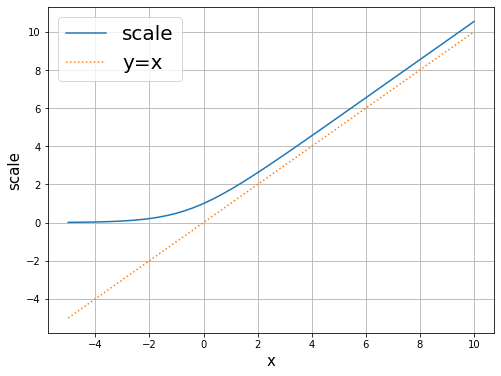

In [11]:
c = np.log(np.expm1(1.0))

x_plot = np.linspace(-5, 10)
scale = (1e-5 + tf.nn.softplus(c + x_plot)).numpy()

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, scale, label='scale')
ax.plot(x_plot, x_plot, label='y=x', ls=':')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('scale', fontsize=15)
ax.legend(fontsize=20)
ax.grid()

In [12]:
batch_shape = train_dataset.element_spec[0].shape
num_classes = mnist_info.features['label'].num_classes
print(batch_shape)
print(num_classes)

(None, 1, 28, 28)
10


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(batch_shape=batch_shape),
    extfp.layers.Conv2DVariational(
        filters=32,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    extfp.layers.Conv2DVariational(
        filters=64,
        kernel_size=(5, 5),
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.GlobalAveragePooling2D(),
    tfp.layers.DenseVariational(
        units=128,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tf.keras.layers.Activation(tf.nn.softplus),
    tfp.layers.DenseVariational(
        units=10,
        make_posterior_fn=extfp.layers.posterior_mean_field,
        make_prior_fn=extfp.layers.prior_trainable,
        kl_weight=kl_weight),
    tfpl.OneHotCategorical(num_classes),
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_variational (Conv2DVa (None, 32, 24, 24)        2496      
_________________________________________________________________
activation (Activation)      (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_variational_1 (Conv2D (None, 64, 20, 20)        153792    
_________________________________________________________________
activation_1 (Activation)    (None, 64, 20, 20)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 6, 6)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense_variational (DenseVari (None, 128)               2

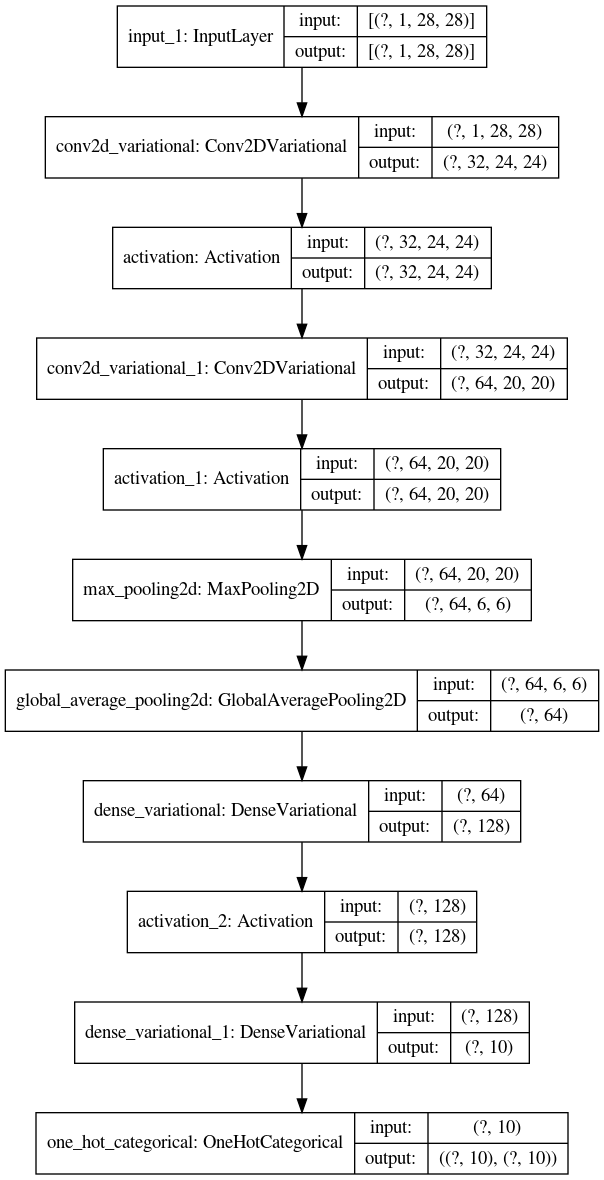

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='/tmp/model.png')

# Training

### Theory
$$
\large \mathcal{L}_{VI}(\theta) := -\frac{N}{M}\sum_{i \in S} \int q_{\theta}(\omega) \log p(\mathbf{y}_{i}|\textbf{f}^{\omega}(\mathbf{x}_{i})) \text{d} \omega + \text{KL}(q_{\theta}(\omega)||p(\omega))
$$
with a random index set $S$ of size $M$.



### Codes
```python
def negative_log_likelihood(y_true, y_pred_distribution):
    return -y_pred_distribution.log_prob(y_true)


def kl_divergence_fn(distribution_a, distribution_b):
    z = test_points_fn(distribution_a)
    return tf.reduce_mean(
        input_tensor=distribution_a.log_prob(z) - distribution_b.log_prob(z),
        axis=test_points_reduce_axis)
```

You can find out [more about the implementation of KL divergence.](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/layers/dense_variational_v2.py#L159-L163)

In [16]:
model.compile(loss=extfp.losses.negative_log_likelihood,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['accuracy'])

In [17]:
# TODO how to save model with variational layers
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5),
]

In [18]:
history = model.fit(train_dataset,
          epochs=500,
          shuffle=True,
          verbose=2,
          validation_data=valid_dataset,
          callbacks=callbacks)

Epoch 1/500
192/192 - 11s - loss: 563.3921 - accuracy: 0.1058 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
192/192 - 7s - loss: 2.9769 - accuracy: 0.1164 - val_loss: 2.4777 - val_accuracy: 0.1325
Epoch 3/500
192/192 - 7s - loss: 2.6058 - accuracy: 0.1178 - val_loss: 2.5042 - val_accuracy: 0.1147
Epoch 4/500
192/192 - 7s - loss: 2.4609 - accuracy: 0.1229 - val_loss: 2.4134 - val_accuracy: 0.1405
Epoch 5/500
192/192 - 7s - loss: 2.3970 - accuracy: 0.1436 - val_loss: 2.4287 - val_accuracy: 0.1690
Epoch 6/500
192/192 - 7s - loss: 2.2782 - accuracy: 0.1701 - val_loss: 2.2303 - val_accuracy: 0.1698
Epoch 7/500
192/192 - 7s - loss: 2.2200 - accuracy: 0.1799 - val_loss: 2.1682 - val_accuracy: 0.1859
Epoch 8/500
192/192 - 7s - loss: 2.1428 - accuracy: 0.1911 - val_loss: 2.1505 - val_accuracy: 0.1822
Epoch 9/500
192/192 - 7s - loss: 2.1262 - accuracy: 0.1908 - val_loss: 2.1163 - val_accuracy: 0.1931
Epoch 10/500
192/192 - 7s - loss: 2.0930 - accuracy: 0.2013 - val_loss: 2.0936 -

Epoch 82/500
192/192 - 7s - loss: 0.1855 - accuracy: 0.9386 - val_loss: 0.2306 - val_accuracy: 0.9285
Epoch 83/500
192/192 - 7s - loss: 0.1886 - accuracy: 0.9398 - val_loss: 0.2132 - val_accuracy: 0.9288
Epoch 84/500
192/192 - 7s - loss: 0.1575 - accuracy: 0.9472 - val_loss: 0.1828 - val_accuracy: 0.9373
Epoch 85/500
192/192 - 7s - loss: 0.1481 - accuracy: 0.9480 - val_loss: 0.1859 - val_accuracy: 0.9390
Epoch 86/500
192/192 - 7s - loss: 0.1490 - accuracy: 0.9474 - val_loss: 0.1711 - val_accuracy: 0.9435
Epoch 87/500
192/192 - 7s - loss: 0.1467 - accuracy: 0.9473 - val_loss: 0.1966 - val_accuracy: 0.9299
Epoch 88/500
192/192 - 7s - loss: 0.1506 - accuracy: 0.9475 - val_loss: 0.1930 - val_accuracy: 0.9368
Epoch 89/500
192/192 - 7s - loss: 0.1519 - accuracy: 0.9470 - val_loss: 0.2072 - val_accuracy: 0.9345
Epoch 90/500
192/192 - 7s - loss: 0.1514 - accuracy: 0.9481 - val_loss: 0.1826 - val_accuracy: 0.9399
Epoch 91/500
192/192 - 7s - loss: 0.1491 - accuracy: 0.9487 - val_loss: 0.1901 - v

Text(0, 0.5, 'Learning Rate')

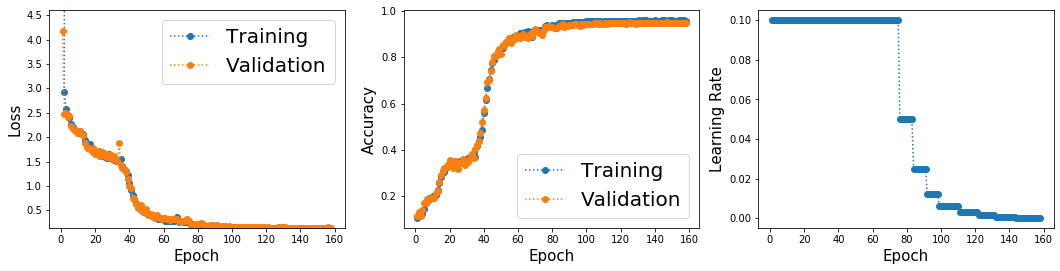

In [19]:
fig, axarr = plt.subplots(ncols=3, figsize=(18, 4))

epoch = list(range(1, len(history.history['loss']) + 1))

plot_kwargs = {
    'ls': ':',
    'marker': 'o'
}

val_loss = history.history['val_loss']

axarr[0].plot(epoch, history.history['loss'], label='Training', **plot_kwargs)
axarr[0].plot(epoch, val_loss, label='Validation', **plot_kwargs)
axarr[0].set_xlabel('Epoch', fontsize=15)
axarr[0].set_ylabel('Loss', fontsize=15)
axarr[0].set_ylim(min(val_loss), 1.1 * max(val_loss))
axarr[0].legend(fontsize=20)


axarr[1].plot(epoch, history.history['accuracy'], label='Training', **plot_kwargs)
axarr[1].plot(epoch, history.history['val_accuracy'], label='Validation', **plot_kwargs)
axarr[1].set_xlabel('Epoch', fontsize=15)
axarr[1].set_ylabel('Accuracy', fontsize=15)
axarr[1].legend(fontsize=20)

axarr[2].plot(epoch, history.history['lr'], **plot_kwargs)
axarr[2].set_xlabel('Epoch', fontsize=15)
axarr[2].set_ylabel('Learning Rate', fontsize=15)

### Evaluation

In [20]:
def sample_prediction(model, x, num_monte_carlo=100):
    assert isinstance(model.layers[-1], tfpl.OneHotCategorical)
    y_dist = model(x)
    y_samples = y_dist.sample(num_monte_carlo)
    return tf.argmax(tf.reduce_sum(y_samples, axis=0), axis=1)

In [21]:
test_accuracy = tf.keras.metrics.Accuracy()
for x, y_true in test_dataset:
    y_pred = sample_prediction(model, x)
    test_accuracy.update_state(
        y_true=tf.argmax(y_true, axis=1),
        y_pred=y_pred)
print('Accuracy: {:.2f}'.format(100 * test_accuracy.result().numpy()))

Accuracy: 96.50


# Out-of-distribution

### Fashion-MNIST

In [22]:
fashion_dataset = tfds.load('fashion_mnist', split=tfds.Split.TEST)

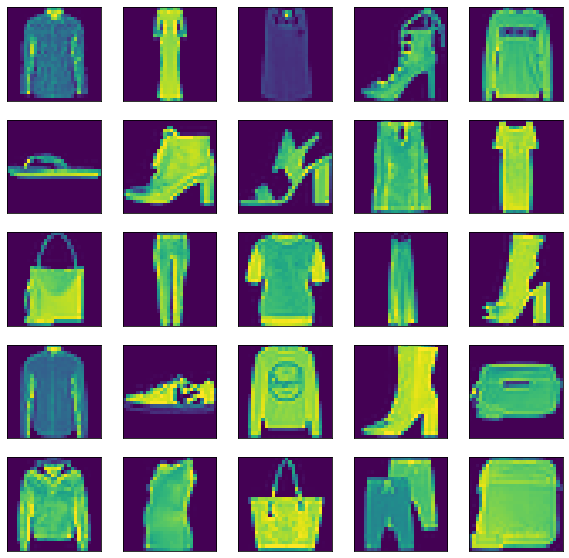

In [23]:
fashion_dataset = (fashion_dataset
                   .map(preprocess_mnist)
                   .batch(256))

fashion_image, _ = next(tfds.as_numpy(fashion_dataset))
visualize_mnist(fashion_image[:25])

### EMNIST - letters

In [24]:
def preprocess_emnist_letters(example):
    '''
    EMNIST/letters
    '''
    image = tf.cast(example['image'], tf.float32) / 255.
    image = tf.transpose(image, (2, 0, 1))
    # Original images are inverted horizontally and rotated 90 anti-clockwise.
    image = tf.transpose(image, (0, 2, 1))
    
    # Label starts from 1
    label = example['label'] - 1
    label = tf.one_hot(indices=label, depth=26, dtype=np.int64)
    return image, label

In [25]:
letters_dataset = tfds.load('emnist/letters', split=tfds.Split.ALL)

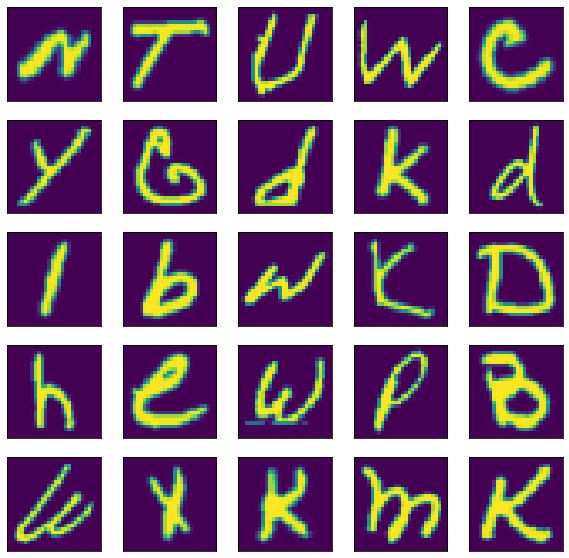

In [26]:
letters_dataset = (letters_dataset
                   .map(preprocess_emnist_letters)
                   .batch(512))
                   
letters_image, _ = next(tfds.as_numpy(letters_dataset))
visualize_mnist(letters_image[:25])

# 

In [27]:
def sample_probability(model, data, num_samples=100):
    assert isinstance(model.layers[-1], tfpl.OneHotCategorical)
    samples = [model.predict_on_batch(data).probs_parameter() for _ in range(num_samples)]
    return tf.stack(samples)

In [28]:
test_probs = []
for x, _ in tqdm_notebook(test_dataset):
    probs = sample_probability(model, x)
    test_probs.append(probs)

test_probs = tf.concat(test_probs, axis=1)

In [29]:
fashion_probs = []
for x in tqdm_notebook(fashion_dataset):
    probs = sample_probability(model, x)
    fashion_probs.append(probs)
fashion_probs = tf.concat(fashion_probs, axis=1)

In [30]:
letters_probs = []
for x in tqdm_notebook(letters_dataset):
    probs = sample_probability(model, x)
    letters_probs.append(probs)
letters_probs = tf.concat(letters_probs, axis=1)

In [35]:
def plot_uncertainty(uncertainties, xlabel, bins=200, log_y=False):
    def to_numpy(arg):
        if isinstance(arg, np.ndarray):
            return arg
        elif isinstance(arg, tf.Tensor):
            return arg.numpy()
        else:
            raise TypeError
            
    uncertainties = [(to_numpy(uncertainty), label) for uncertainty, label in uncertainties]    
    x_max = max(each.max() for each, _ in uncertainties)
    
    hist_kwargs = {
        'alpha': 0.3,
        'range': (0, x_max),
        'bins': bins,
        'density': True
    }
    
    bin_width = x_max / bins
    ylabel = 'Frequency density (bin width = {:5f})'.format(bin_width)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for uncertainty, label in uncertainties:
        ax.hist(uncertainty, label=label, **hist_kwargs)

    ax.legend(fontsize=20)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    
    if log_y:
        ax.set_yscale('log')

## Variational-Ratio

### Theory
* $\large \text{variation-ratio}[\mathbf{x}] := 1 - \frac{f_{\mathbf{x}}}{T}$
* $\large c^{*} = \underset{c=1,\ldots,C}{\text{argmax}} \sum_{t}\mathbb{1}[y^{t}=c]$
* $\large f_{\mathbf{x}} = \sum_{t} \mathbb{1}[y^{t}=c^{*}]$


### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L5-L20)
```python
def compute_variation_ratio(prob_samples):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    num_samples = len(prob_samples)
    mode = tf.reduce_max(prob_samples, axis=2, keepdims=True)
    is_mode = tf.dtypes.cast(prob_samples == mode, prob_samples.dtype)
    num_mode = tf.reduce_sum(is_mode, axis=2, keepdims=True)
    mode_frequency = tf.reduce_max(tf.reduce_sum(is_mode / num_mode, axis=0), axis=1)
    return 1 - (mode_frequency / num_samples)
```

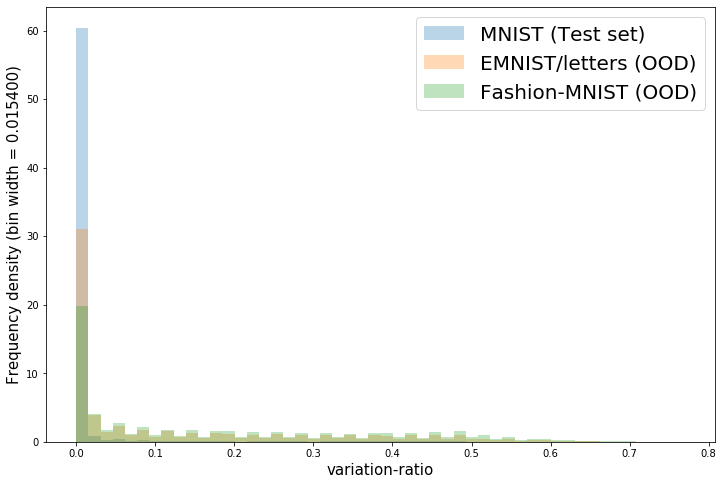

In [36]:
variation_ratio_test = extfp.uncertainty.compute_variation_ratio(test_probs)
variation_ratio_fashion = extfp.uncertainty.compute_variation_ratio(fashion_probs)
variation_ratio_letters = extfp.uncertainty.compute_variation_ratio(letters_probs)

variation_ratio = [
    (variation_ratio_test, 'MNIST (Test set)'),
    (variation_ratio_letters, 'EMNIST/letters (OOD)'),
    (variation_ratio_fashion, 'Fashion-MNIST (OOD)'),
]

plot_uncertainty(variation_ratio, 'variation-ratio', bins=50)

# Predictive Entropy

### Theory
* $\large \mathbb{H}[y|\mathbf{x},\mathcal{D}] := -\sum_{c} p(y=c|\mathbf{x},\mathcal{D}_{train}) \log p(y=c|\mathbf{x},\mathcal{D}_{train})$

* $\large [p(y=1|\mathbf{x},\hat{\omega}_{t}) , \ldots , p(y=C|\mathbf{x},\hat{\omega}_{t})] := \text{Softmax}(\textbf{f}^{\hat{\omega}_{t}}(\mathbf{x}))$

* $\large \tilde{\mathbb{H}}[y|\mathbf{x},\mathcal{D}] = - \sum_{c} (\frac{1}{T} \sum_{t}p(y=c|\mathbf{x},\hat{\omega}_{t})) \log (\frac{1}{T} \sum_{t}p(y=c|\mathbf{x},\hat{\omega}_{t}))$

### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L23-L36)
```python
def compute_predictive_entropy(prob_samples, eps=1e-12):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    # predictive probability
    pred_prob = tf.reduce_mean(prob_samples, axis=0)
    pred_log_prob = tf.math.log(tf.clip_by_value(pred_prob, eps, 1))
    return -tf.reduce_sum(pred_prob * pred_log_prob, axis=1)
```

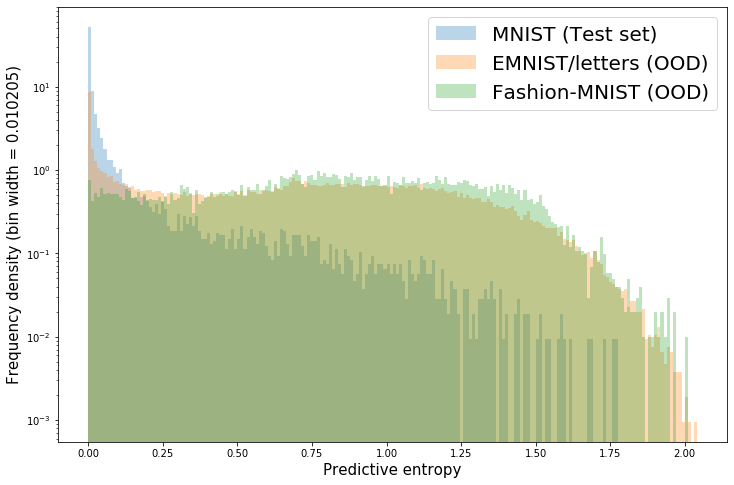

In [37]:
pred_entropy_test = extfp.uncertainty.compute_predictive_entropy(test_probs)
pred_entropy_fashion = extfp.uncertainty.compute_predictive_entropy(fashion_probs)
pred_entropy_letters = extfp.uncertainty.compute_predictive_entropy(letters_probs)

pred_entropy = [
    (pred_entropy_test, 'MNIST (Test set)'),
    (pred_entropy_letters, 'EMNIST/letters (OOD)'),
    (pred_entropy_fashion, 'Fashion-MNIST (OOD)'),
]

plot_uncertainty(pred_entropy, 'Predictive entropy', log_y=True)

# Mutual Information

### Theory
* $\large \mathbb{I}[y,\omega|\mathbf{x},\mathcal{D}_{\text{train}}] := \mathbb{H}[y|\mathbf{x},\mathcal{D}_{\text{train}}] - \mathbb{E}_{p(\omega|\mathcal{D}_{\text{train}})}\mathbb{H}[y|\mathbf{x},\omega]$

* $\large \tilde{\mathbb{I}}[y,\omega|\mathbf{x},\mathcal{D}_{\text{train}}] := \tilde{\mathbb{H}}[y|\mathbf{x},\mathcal{D}_\text{train}] + \frac{1}{T} \sum_{c,t} p(y=c|\mathbf{x},\hat{\omega}_{t}) \log p(y=c|\mathbf{x},\hat{\omega}_{t})$

### [Code](https://github.com/seungjin-yang/extended-tensorflow-probability/blob/8cc5844cf6d00db72ad4f26f584f75d04d5ad021/extended_tfp/uncertainty.py#L39-L53)
```python
def compute_mutual_information(prob_samples, eps=1e-12):
    '''
    Referenced 3.3.1 of following thesis.
        Y. Gal, "Uncertainty in Deep Learning", University of Cambridge (2016)
    Args:
      prob_samples: [num_samples, batch_size, num_classes]
    Returns:
      variation_ratio: [batch_size]
    '''
    predictive_entropy = compute_predictive_entropy(prob_samples)

    log_prob_samples = tf.math.log(tf.clip_by_value(prob_samples, eps, 1))
    neg_entropy_samples = tf.reduce_sum(prob_samples * log_prob_samples, axis=2)
    return predictive_entropy + tf.reduce_mean(neg_entropy_samples, axis=0)
```

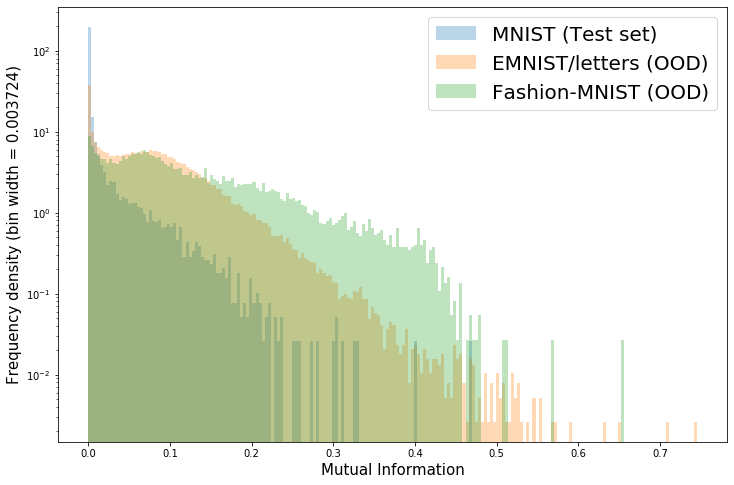

In [38]:
mutual_info_test = extfp.uncertainty.compute_mutual_information(test_probs)
mutual_info_fashion = extfp.uncertainty.compute_mutual_information(fashion_probs)
mutual_info_letters = extfp.uncertainty.compute_mutual_information(letters_probs)

mutual_info = [
    (mutual_info_test, 'MNIST (Test set)'),
    (mutual_info_letters, 'EMNIST/letters (OOD)'),
    (mutual_info_fashion, 'Fashion-MNIST (OOD)'),
]

plot_uncertainty(mutual_info, 'Mutual Information', log_y=True)